In [1]:
import numpy as np
import pandas as pd

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
f_mnist_full = pd.read_csv('data/fashion-mnist.csv')
print(f_mnist_full.shape)

(60000, 785)


In [3]:
f_mnist_full.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
sorted = f_mnist_full.sort_values('label')
sorted.set_index(keys=['label'], drop=False,inplace=True)
# get a list of names
labels = sorted['label'].unique().tolist()
# now we can perform a lookup on a 'view' of the dataframe
f_mnist = pd.DataFrame(columns = f_mnist_full.columns)
for label in labels:
    df  = (sorted.loc[sorted.label == label]).sample(1500)
    f_mnist = f_mnist.append(df)
    
f_mnist

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,8,5,6,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,26,...,174,186,161,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,154,146,175,103,0,4,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,22,29,30,27,29,22,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,90,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


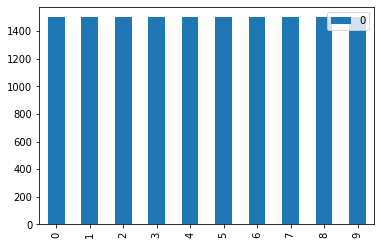

In [9]:
from collections import Counter

count = Counter(f_mnist['label'])
df = pd.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')

In [10]:
# new labels: 1 = top wear (shirt, pullover, dress, coat, shirt), 0 = not top wear
f_mnist['label'] = f_mnist['label'].map({
    0: 1,
    2: 1,
    3: 1,
    4: 1,
    6: 1,
    1: 0,
    5: 0,
    7: 0,
    8: 0,
    9: 0
})

In [11]:
f_mnist.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,1,0,0,0,0,0,0,0,0,0,...,8,5,6,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,26,...,174,186,161,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,...,154,146,175,103,0,4,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,...,22,29,30,27,29,22,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,...,90,0,0,0,2,0,0,0,0,0


In [12]:
f_mnist.dropna(inplace = True)
f_mnist.shape

(15000, 785)

In [13]:
X = f_mnist.drop(['label'], axis = 1)
y = f_mnist['label']

In [19]:
def findBest(model, params, X_train, y_train):
    opt_model = GridSearchCV(model, params, scoring = ['accuracy', 'f1'], refit = 'accuracy', verbose = 1, n_jobs = -1)
    opt_model.fit(X_train, y_train)
    
    print(opt_model.best_score_)
    print(opt_model.best_params_)
    return opt_model

In [15]:
def prepData(X, y, partition, categorical):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = partition)
    
#     for feature in categorical:
#         label_encoder = LabelEncoder()
#         label_encoder.fit(X[feature])
#         X_train[feature] = label_encoder.transform(X_train[feature])
#         X_test[feature] = label_encoder.transform(X_test[feature])

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)
    
    return X_train, X_test, y_train, y_test

In [16]:
def evalModels(mp_dict, trials, partitions, categorical, X, y):
    results = {}
    trainEval = {}
    testEval = {}
    detailRes = {}
    for p in partitions:
        results[str(p)] = {}
        trainEval[str(p)] = {}
        testEval[str(p)] = {}
        detailRes[str(p)] = {}
        print("Evaluating partition for: test_size = " + str(p))
        X_train, X_test, y_train, y_test = prepData(X, y, p, categorical)

        for model in mp_dict:
            print("Starting new Model: " + str(model))
            
            acc_list = []
            acc_dict = {}
            for iteration in range(0, trials):
                print("Starting iteration " + str(iteration + 1))
                opt_model = findBest(model, mp_dict[model], X_train, y_train)
                detailRes[str(p)][type(opt_model.best_estimator_).__name__] = {}
                detailRes[str(p)][type(opt_model.best_estimator_).__name__][str(iteration)] = opt_model
                acc_dict[str(opt_model.best_score_)] = opt_model
                acc_list.append(opt_model.best_score_)
                    
            med_acc = np.median(acc_list)
            best_model = acc_dict[str(med_acc)]
            
            train_acc, train_f1 = testModel(X_train, y_train, best_model)
            trainEval[str(p)][type(best_model.best_estimator_).__name__] = {"accuracy": train_acc, "f1": train_f1}
            
            test_acc, test_f1 = testModel(X_test, y_test, best_model)
            testEval[str(p)][type(best_model.best_estimator_).__name__] = {"accuracy": test_acc, "f1": test_f1}
            
            results[str(p)][type(best_model.best_estimator_).__name__] = best_model
            print("Best acc score for " + str(model))
            print(best_model.best_score_)
            
    return results, trainEval, testEval

In [17]:
def testModel(X, y, classifier):
    Y_pred = classifier.predict(X)
    acc = accuracy_score(y, Y_pred)
    f1 = f1_score(y, Y_pred)
    return acc, f1

In [18]:
def resultSummary(result):
    sl = ["params", "mean_test_accuracy", "std_test_accuracy", "mean_test_f1", "std_test_f1"]
    resultSum = {}
    for p in result:
        resultSum[p] = {}
        for modelName in result[p]:
            resultSum[p][modelName] = {key: result[p][modelName].cv_results_[key][result[p][modelName].best_index_] for key in sl}
    return resultSum

In [20]:
mp_dict = {
    LogisticRegression(): {
        'C': [10 ** i for i in range(-8, 4)]
    },
    LinearSVC(): {
        'C': [10 ** i for i in range(-5, 3)]
    },
#     SVC(kernel = 'poly'): {
#         'C': [10 ** i for i in range(-5, 3)],
#         'degree': [i for i in range(1, 4)]
#     },
    KNeighborsClassifier(): {
        'n_neighbors': [1, 2, 3, 5, 7, 10, 15, 25, 50, 100, 500]
    },
    RandomForestClassifier(): {
        'max_features': [1, 2, 4, 6, 8, 12 ,16, 20],
        'n_estimators': [1024]
    },
    GradientBoostingClassifier(): {
        'n_estimators': [2, 4, 8, 16, 32, 64, 128, 512, 1024]
    }
}
categorical = []
trials = 3
partitions = [0.2, 0.5, 0.8]


result, trainEval, testEval = evalModels(mp_dict, trials, partitions, categorical, X, y)

Evaluating partition for: test_size = 0.2
Starting new Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Starting iteration 1
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   42.0s finished


0.9771666666666666
{'C': 0.01}
Starting iteration 2
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   42.2s finished


0.9771666666666666
{'C': 0.01}
Starting iteration 3
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   40.5s finished


0.9771666666666666
{'C': 0.01}
Best acc score for LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.9771666666666666
Starting new Model: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Starting iteration 1
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   44.8s finished


0.9774166666666666
{'C': 0.001}
Starting iteration 2
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   44.1s finished


0.9774166666666666
{'C': 0.001}
Starting iteration 3
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   43.9s finished


0.9774166666666666
{'C': 0.001}
Best acc score for LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
0.9774166666666666
Starting new Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Starting iteration 1
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed: 15.0min finished


0.9829166666666668
{'n_neighbors': 2}
Starting iteration 2
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed: 15.0min finished


0.9829166666666668
{'n_neighbors': 2}
Starting iteration 3
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed: 14.8min finished


0.9829166666666668
{'n_neighbors': 2}
Best acc score for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
0.9829166666666668
Starting new Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Starting iteration 1
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/eric/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  7.0min finished


0.9878333333333333
{'max_features': 12, 'n_estimators': 1024}
Starting iteration 2
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/eric/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  7.0min finished


0.9881666666666666
{'max_features': 20, 'n_estimators': 1024}
Starting iteration 3
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/eric/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.9min finished


0.9880833333333333
{'max_features': 12, 'n_estimators': 1024}
Best acc score for RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.9880833333333333
Starting new Model: GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_s

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 43.4min finished


0.9883333333333333
{'n_estimators': 512}
Starting iteration 2
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 42.9min finished


0.9884166666666665
{'n_estimators': 1024}
Starting iteration 3
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 43.3min finished


0.9883333333333333
{'n_estimators': 1024}
Best acc score for GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.9883333333333333
Evaluating partition for: test_size = 0.5
Starting new Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
               

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   27.5s finished


0.9757333333333333
{'C': 0.01}
Starting iteration 2
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   24.2s finished


0.9757333333333333
{'C': 0.01}
Starting iteration 3
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   24.3s finished


0.9757333333333333
{'C': 0.01}
Best acc score for LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.9757333333333333
Starting new Model: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Starting iteration 1
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   24.6s finished


0.9754666666666667
{'C': 0.001}
Starting iteration 2
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   25.2s finished


0.9754666666666667
{'C': 0.001}
Starting iteration 3
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   25.2s finished


0.9754666666666667
{'C': 0.001}
Best acc score for LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
0.9754666666666667
Starting new Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Starting iteration 1
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  5.6min finished


0.9804
{'n_neighbors': 2}
Starting iteration 2
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  5.7min finished


0.9804
{'n_neighbors': 2}
Starting iteration 3
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  5.6min finished


0.9804
{'n_neighbors': 2}
Best acc score for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
0.9804
Starting new Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Starting iteration 1
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.7min finished


0.986
{'max_features': 12, 'n_estimators': 1024}
Starting iteration 2
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.3min finished


0.9861333333333333
{'max_features': 6, 'n_estimators': 1024}
Starting iteration 3
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.1min finished


0.9862666666666666
{'max_features': 8, 'n_estimators': 1024}
Best acc score for RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.9861333333333333
Starting new Model: GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_sa

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 27.0min finished


0.9856
{'n_estimators': 1024}
Starting iteration 2
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 26.7min finished


0.9853333333333334
{'n_estimators': 1024}
Starting iteration 3
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 26.4min finished


0.9852000000000001
{'n_estimators': 1024}
Best acc score for GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.9853333333333334
Evaluating partition for: test_size = 0.8
Starting new Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
               

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   13.4s finished


0.9763333333333334
{'C': 0.01}
Starting iteration 2
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   10.5s finished


0.9763333333333334
{'C': 0.01}
Starting iteration 3
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   10.5s finished


0.9763333333333334
{'C': 0.01}
Best acc score for LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.9763333333333334
Starting new Model: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Starting iteration 1
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.0s finished


0.9766666666666668
{'C': 0.001}
Starting iteration 2
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.7s finished


0.9766666666666668
{'C': 0.001}
Starting iteration 3
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.1s finished


0.9766666666666668
{'C': 0.001}
Best acc score for LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
0.9766666666666668
Starting new Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Starting iteration 1
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.9766666666666666
{'n_neighbors': 3}
Starting iteration 2
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.9766666666666666
{'n_neighbors': 3}
Starting iteration 3
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   57.8s finished


0.9766666666666666
{'n_neighbors': 3}
Best acc score for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
0.9766666666666666
Starting new Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Starting iteration 1
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.5min finished


0.9853333333333334
{'max_features': 20, 'n_estimators': 1024}
Starting iteration 2
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.4min finished


0.985
{'max_features': 12, 'n_estimators': 1024}
Starting iteration 3
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.5min finished


0.9853333333333334
{'max_features': 12, 'n_estimators': 1024}
Best acc score for RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.9853333333333334
Starting new Model: GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_s

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  6.4min finished


0.985
{'n_estimators': 1024}
Starting iteration 2
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  6.4min finished


0.985
{'n_estimators': 512}
Starting iteration 3
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  6.5min finished


0.985
{'n_estimators': 512}
Best acc score for GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.985


In [21]:
print("Summary of results: ")
resultSum = resultSummary(result)
print(resultSum)
print("Test evals: ")
print(testEval)

Summary of results: 
{'0.2': {'LogisticRegression': {'params': {'C': 0.01}, 'mean_test_accuracy': 0.9771666666666666, 'std_test_accuracy': 0.0019965247584518386, 'mean_test_f1': 0.9774886805621117, 'std_test_f1': 0.002007277080782138}, 'LinearSVC': {'params': {'C': 0.001}, 'mean_test_accuracy': 0.9774166666666666, 'std_test_accuracy': 0.0018142950880897836, 'mean_test_f1': 0.9777601722533547, 'std_test_f1': 0.0018148967652569226}, 'KNeighborsClassifier': {'params': {'n_neighbors': 2}, 'mean_test_accuracy': 0.9829166666666668, 'std_test_accuracy': 0.0026744677559802084, 'mean_test_f1': 0.9830731441921298, 'std_test_f1': 0.0026337498807376854}, 'RandomForestClassifier': {'params': {'max_features': 12, 'n_estimators': 1024}, 'mean_test_accuracy': 0.9880833333333333, 'std_test_accuracy': 0.002260776661041743, 'mean_test_f1': 0.9882370615471265, 'std_test_f1': 0.002253190665175986}, 'GradientBoostingClassifier': {'params': {'n_estimators': 1024}, 'mean_test_accuracy': 0.9883333333333333, 's

In [22]:
import csv
csv_columns = ["Model", "Partition", "Params", "Train_Acc", "Train_F1", "Val_Acc", "Val_F1", "Test_Acc", "Test_F1", "Acc_Std", "F1_Std"]
csv_file = "F_MNIST_EvalResults.csv"
try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(csv_columns)
        
        modelList = resultSum['0.2'].keys()
        for modelName in modelList:
            for partition in resultSum:
                params = resultSum[partition][modelName]['params']
                val_acc_std = resultSum[partition][modelName]['std_test_accuracy']
                val_acc = resultSum[partition][modelName]['mean_test_accuracy']
                val_f1_std = resultSum[partition][modelName]['std_test_f1']
                val_f1 = resultSum[partition][modelName]['mean_test_f1']
                
                test_acc = testEval[partition][modelName]['accuracy']
                test_f1 = testEval[partition][modelName]['f1']
                
                train_acc = trainEval[partition][modelName]['accuracy']
                train_f1 = trainEval[partition][modelName]['f1']
                
                writer.writerow([modelName, partition, params, train_acc, train_f1, val_acc, val_f1, test_acc, test_f1, val_acc_std, val_f1_std])

except IOError:
    print("I/O error")

In [23]:
result_df = pd.read_csv("F_MNIST_EvalResults.csv")
result_df

,Model,Partition,Params,Train_Acc,Train_F1,Val_Acc,Val_F1,Test_Acc,Test_F1,Acc_Std,F1_Std
0,LogisticRegression,0.2,{'C': 0.01},0.984667,0.984866,0.977167,0.977489,0.979667,0.979131,0.001997,0.002007
1,LogisticRegression,0.5,{'C': 0.01},0.984000,0.984085,0.975733,0.975873,0.976667,0.976837,0.004892,0.004841
2,LogisticRegression,0.8,{'C': 0.01},0.989000,0.989338,0.976333,0.977170,0.977917,0.977941,0.006864,0.006477
3,LinearSVC,0.2,{'C': 0.001},0.984833,0.985030,0.977417,0.977760,0.980333,0.979843,0.001814,0.001815
4,LinearSVC,0.5,{'C': 0.001},0.984400,0.984485,0.975467,0.975651,0.977200,0.977396,0.004204,0.004157
5,LinearSVC,0.8,{'C': 0.001},0.990333,0.990618,0.976667,0.977475,0.978583,0.978617,0.007601,0.007260
6,KNeighborsClassifier,0.2,{'n_neighbors': 2},0.996500,0.996514,0.982917,0.983073,0.984667,0.984192,0.002674,0.002634
7,KNeighborsClassifier,0.5,{'n_neighbors': 2},0.995200,0.995173,0.980400,0.980431,0.984000,0.984026,0.003642,0.003628
8,KNeighborsClassifier,0.8,{'n_neighbors': 3},0.983667,0.984239,0.976667,0.977634,0.975500,0.975755,0.005774,0.005441
9,RandomForestClassifier,0.2,"{'max_features': 12, 'n_estimators': 1024}",1.000000,1.000000,0.988083,0.988237,0.987667,0.987359,0.002261,0.002253
